In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [4]:
data = pd.read_csv('./bike.csv', thousands = ',')
y = pd.DataFrame(data.parkingBikeTotCnt)

y = y[:2160]

scaler = MinMaxScaler()
y = scaler.fit_transform(y)
y.shape

(1748, 1)

In [5]:
p1 = int(len(y) * 0.85)
train, test = y[:p1], y[p1:]
print(len(train), len(test))

1485 263


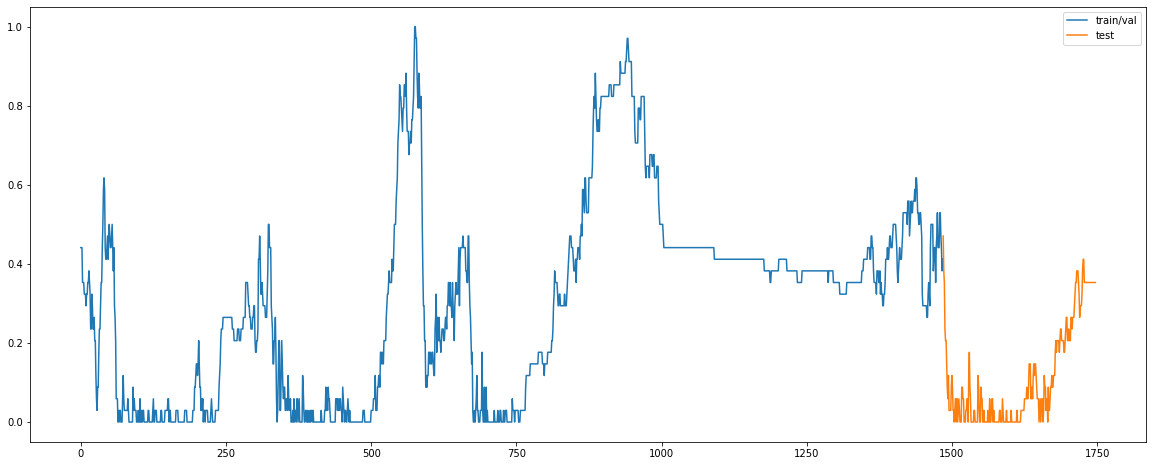

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(range(0, p1), train, label="train/val")
plt.plot(range(p1, len(y)), test, label="test")

plt.legend()

In [7]:
def create_dataset(dataset, look_back=5, nPredicted = 5):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-nPredicted + 1):
		dataX.append(dataset[i:(i+look_back), 0])
		dataY.append(dataset[i + look_back: i + look_back + nPredicted, 0])
	return np.array(dataX), np.array(dataY)

In [48]:
look_back = 18
nPredicted = 6

# Create Shifted Dataset
trainX, trainY = create_dataset(train, look_back, nPredicted)
testX, testY = create_dataset(test, look_back, nPredicted)

# Reshape
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainY = np.reshape(trainY, (trainY.shape[0], trainY.shape[1], 1))
testY = np.reshape(testY, (testY.shape[0], testY.shape[1], 1))

print(trainX.shape, trainY.shape)

(1462, 18, 1) (1462, 6, 1)


In [49]:
model = Sequential()

model.add(LSTM(20, activation='linear', input_shape=(look_back, 1)))
model.add(RepeatVector(nPredicted))
model.add(LSTM(20, activation='linear', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 20)                1760      
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 6, 20)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 6, 20)             3280      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 6, 1)              21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [50]:
import time
start = time.time()

history = model.fit(trainX, trainY, epochs=65, batch_size=64)

print("학습시간 :", time.time() - start)
print("last loss :", history.history['loss'][-1:])

Epoch 1/65
1462/1462 [==============================] - 1s 692us/step - loss: 0.0665
Epoch 2/65
1462/1462 [==============================] - 0s 194us/step - loss: 0.0278
Epoch 3/65
1462/1462 [==============================] - 0s 200us/step - loss: 0.0210
Epoch 4/65
1462/1462 [==============================] - 0s 192us/step - loss: 0.0162
Epoch 5/65
1462/1462 [==============================] - 0s 198us/step - loss: 0.0112
Epoch 6/65
1462/1462 [==============================] - 0s 197us/step - loss: 0.0089
Epoch 7/65
1462/1462 [==============================] - 0s 201us/step - loss: 0.0076
Epoch 8/65
1462/1462 [==============================] - 0s 221us/step - loss: 0.0069
Epoch 9/65
1462/1462 [==============================] - 0s 201us/step - loss: 0.0066
Epoch 10/65
1462/1462 [==============================] - 0s 196us/step - loss: 0.0064
Epoch 11/65
1462/1462 [==============================] - 0s 196us/step - loss: 0.0062
Epoch 12/65
1462/1462 [==============================] - 0s 197

((245, 1), (240, 6))

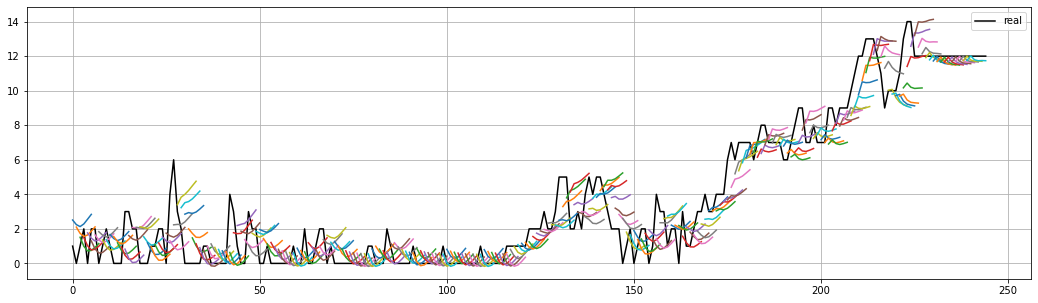

In [51]:
pred = model.predict(testX, batch_size=1)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
pred = scaler.inverse_transform(pred)
#pred = np.around(pred)

plt.figure(figsize=(18, 5))
plt.grid(True)  

real = scaler.inverse_transform(test[look_back:])
plt.plot(real, label="real", color="black")
plt.legend()

for i in range(0, len(pred), 1):
  plt.plot(range(i, i + nPredicted), pred[i])

real.shape, pred.shape

((1467, 1), (1462, 6))

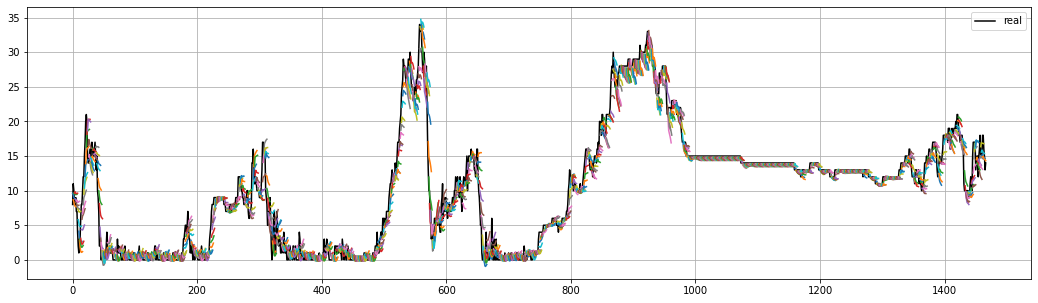

In [52]:
pred = model.predict(trainX, batch_size=1)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
pred = scaler.inverse_transform(pred)
#pred = pred.astype(int)

plt.figure(figsize=(18, 5))
plt.grid(True)

real = scaler.inverse_transform(train[look_back:])
plt.plot(real, label="real", color="black")
plt.legend()

for i in range(0, len(pred), 1):
  plt.plot(range(i, i + nPredicted), pred[i], "-")

real.shape, pred.shape